# Regression_with_an_Insurance_Dataset
- Compétition disponible sur : https://www.kaggle.com/competitions/playground-series-s4e12/overview


## Modélisation SANS les features qualitatives : 

In [19]:
import pandas as pd
import os
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import pandas as pd 
import os
from termcolor import colored


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor

import pickle

import warnings
warnings.filterwarnings("ignore")

In [20]:
splitted_path = os.getcwd().split("\\")[:-1]
path_dataset = "\\".join(splitted_path) + "\\notebook\\"
path_test = "\\".join(splitted_path) + "\\dataset\\"

In [21]:
data = pd.read_csv(path_dataset+r"train_preprocessed_Without_AllFeat.csv",index_col=0)
test = pd.read_csv(path_dataset+"test_preprocessed_Without_AllFeat.csv",index_col=0)
df = data.copy()

In [22]:
print("Dimension :", df.shape)
df.head()

Dimension : (1200000, 10)


,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
0,0,19,-0.707414,1,-0.255071,2,17,-1.565702e+00,5,2869.0
1,1,39,-0.023289,3,-0.849704,1,12,7.163281e-01,2,1483.0
2,2,23,-0.215473,3,1.824212,1,14,-1.611408e-15,3,567.0
3,3,21,3.461605,2,-1.241521,1,0,-1.601137e+00,1,765.0
4,4,21,0.228896,1,-0.443102,0,8,3.597138e-02,4,2022.0


In [23]:
test.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration
0,1200000,28.0,-0.952198,4.0,-1.519011,0.0,19.0,-1.611408e-15,1.0
1,1200001,31.0,2.961093,2.0,-1.034831,0.0,14.0,-1.565702e+00,8.0
2,1200002,47.0,-0.484644,0.0,-0.106539,0.0,16.0,1.602209e+00,9.0
3,1200003,28.0,-0.062953,3.0,-1.732344,1.0,3.0,1.254944e+00,5.0
4,1200004,24.0,-0.681667,2.0,-1.164875,0.0,14.0,1.148638e+00,7.0


In [24]:
X = df.drop(["id","Premium Amount"],axis=1)
y = df["Premium Amount"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [25]:
def train(model):
    """Fonction qui entraine un modèle et affiche le score obtenu sur 5 splits après
    cross validation et le score moyen. 
    Renvoi un tuple de trois éléments :
    (predictions, temps d'execution, le modèle entrainé)"""
    
    scores = cross_val_score(estimator=model, X=X_train.values, y=y_train)
    
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    
    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values)
    
    print(colored(type(model).__name__,"light_green",attrs=["bold"]))
    print("Scores sur 5 splits : ", [i.round(3) for i in scores])
    print("Score moyen :", scores.mean().round(3))

    return (yp, training_time_min, model)

def mesure(prediction, model):
    """
    Renvoi un dataframe contenant les valeurs des différentes
    metrics enregistrées à partir des prédicions d'un modèle:
    RMSLE,RMSE, MSE,MAE & R²
    return : Dataframe
    """

    # Calcul des différentes metrics rmse,mse, mae,R²
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mse = mean_squared_error(y_test, prediction, squared=True)
    mae = median_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)
    

    # Récupération de l'ensemble des metrics
    all_metric = [rmse, mse, mae, r2]
    index_metric = ["RMSE", "MSE", "MAE", "R²"]

    metric_series = pd.Series(all_metric, name=str(model), index=index_metric)

    return pd.DataFrame(metric_series).T

def trainig_series(list_models):
    """Fonction qui entraine en série plusieurs modèle à la fois
    Renvoie un tuple contenant 4 éléments :
    DataFrame contenant toutes les métrics
    DataFrame contenant toutes les prédictions de modèles
    Dictionnaire contenant tout les modèles préentrainés
    Dictionnaire contenant le temps d'entrainement de chaque modèle
    """
    #Dictionnaire qui contiendra les différentes metrics de chaque modèle
    dict_metric = {}
    #dictionnaire contenant les valeurs prédictives pour chaque modèles
    dict_prediction = {}
    #dictionnaire contenant les modele entrainé
    dict_model_trained = {}
    #dictionnaire contenant le temps d'exécution 
    dict_time ={}
        
    
    for current_model in list_models:
        #Recuperation des prédictions et du temps d'execution de chaque modèles
        prediction, temps_exe, model_trained = train(current_model)

        # Récupération du nom du modèle et du chemin d'enregistrement
        model_name = type(current_model).__name__

        # Enregitrement des modèles après entrainement : 
        dict_model_trained[model_name] = model_trained

        #Enregistrement des prédiction dans le dictionnaire :
        dict_prediction[model_name] = prediction

        # Enregistrement des métriques au dictionnaire
        dict_metric[model_name] = mesure(prediction=prediction, model=model_name)
        
        #Enregistrement du tps d'execution
        dict_time[model_name] = temps_exe  
        
    #Pour les Dataframe :    
    # Concaténation des métriques en un DataFrame et inversion des colonnes et index :
    df_metrics = pd.concat(dict_metric.values(), axis=1).T 
    #Enregistrement des prédictions dans un dataframe :
    df_prediction = pd.DataFrame(dict_prediction)
    
    return (df_metrics,df_prediction,dict_model_trained, dict_time)

In [26]:
 #visualisation du temp d'entrainement
def graph_time(dictionnary_time):
    """Fonction qui récupère un dictionnaire contenant les informations sur la durée d'entrainement des modèles et renvoie un barplot"""
    df_time = pd.DataFrame.from_dict(dictionnary_time, orient = "index", columns=["Duree d'entrainement"])
    plt.figure(figsize=(16,4))
    plt.grid()
    ax = sns.barplot(x = df_time.index, y = df_time.columns[0], data = df_time)
    ax.set_xticklabels(labels = df_time.index, rotation = 45)
    plt.xlabel("Modèles")
    plt.title("Durée d'entrainement des différents modèles (en minutes)")
    plt.show()

    
#Visualisation des metrics avec un barplot
def metric_plot(df_metric):
    mesure_reset = df_metric.reset_index()
    # Ensuite, ON utilise melt avec le nouvel index comme id_vars
    metric_df_melt = mesure_reset.melt(id_vars="index", var_name="Model", value_name="Score")

    plt.figure(figsize=(16,6))
    plt.grid()
    sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Comparaison des scores des modèles')
    plt.show()

In [27]:
def visualisation_pred_real(list_model,xsize=14,ysize=14):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    
    plt.figure(figsize=(xsize,ysize))
    for i, model in enumerate(list_model,1):
        plt.subplot(4,2,i)    
        y_pred = list_model[model].predict(X_test)
        plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y

        # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

        # Label et  titre
        plt.title(f'{model}')
        plt.xlabel('Valeurs Réelles')
        plt.ylabel('Valeurs Prédites')
    plt.tight_layout()
    plt.show()

In [29]:
def enregistrement_model(pretrained_models):
    """Prend en entrée un dictionnaire sous forme {nom_modèle : modèle préentrainé}"""
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')


In [30]:
all_model = [DummyRegressor(strategy="mean"), 
              LinearRegression(), 
               Ridge(), Lasso(), ElasticNet(),
             HuberRegressor(), #ajout de ce modèle moins sensible aux outliers
#              SVR(kernel='rbf'), # ajout d'un modèle non linéaire
             
#              RandomForestRegressor(), AdaBoostRegressor(), XGBRegressor()
            ]

In [31]:
#Entrainement en série :
mesure, prediction,model_entraine, exe_time = trainig_series(all_model)

DummyRegressor
Scores sur 5 splits :  [-0.0, -0.0, -0.0, -0.0, -0.0]
Score moyen : -0.0
LinearRegression
Scores sur 5 splits :  [0.003, 0.003, 0.003, 0.003, 0.003]
Score moyen : 0.003
Ridge
Scores sur 5 splits :  [0.003, 0.003, 0.003, 0.003, 0.003]
Score moyen : 0.003
Lasso
Scores sur 5 splits :  [0.003, 0.003, 0.003, 0.003, 0.003]
Score moyen : 0.003
ElasticNet
Scores sur 5 splits :  [0.003, 0.002, 0.003, 0.003, 0.003]
Score moyen : 0.003
HuberRegressor
Scores sur 5 splits :  [-0.037, -0.041, -0.038, -0.037, -0.036]
Score moyen : -0.038


In [32]:
#Sauvegarde des modèles préentrainé :
enregistrement_model(model_entraine)

DummyRegressor enregistré sous DummyRegressor.pkl
LinearRegression enregistré sous LinearRegression.pkl
Ridge enregistré sous Ridge.pkl
Lasso enregistré sous Lasso.pkl
ElasticNet enregistré sous ElasticNet.pkl
HuberRegressor enregistré sous HuberRegressor.pkl


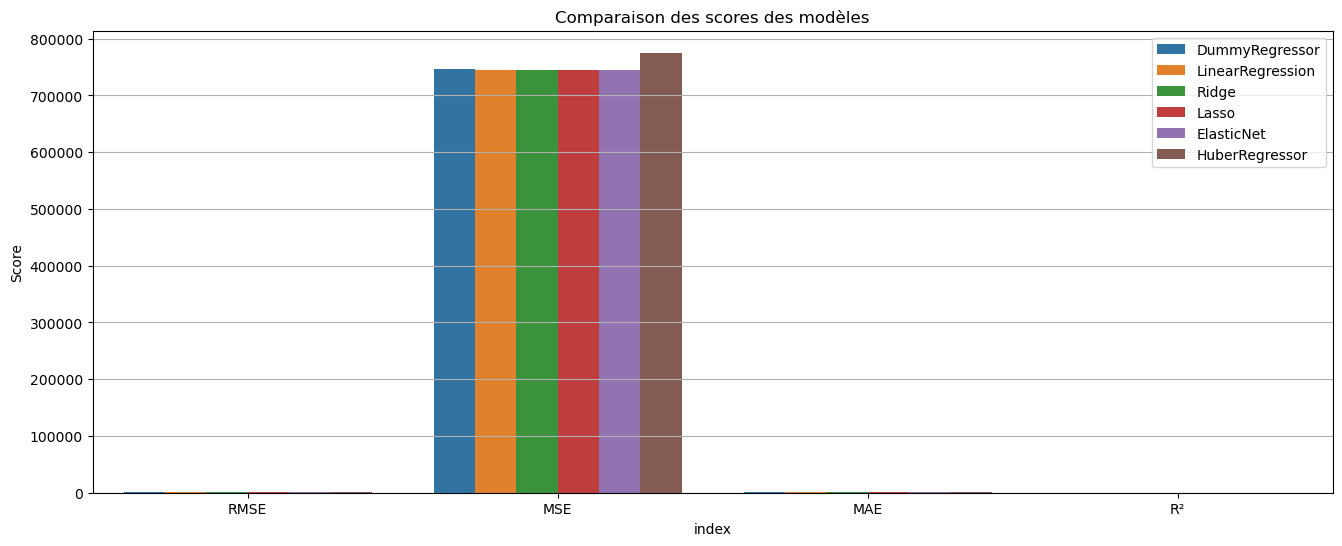

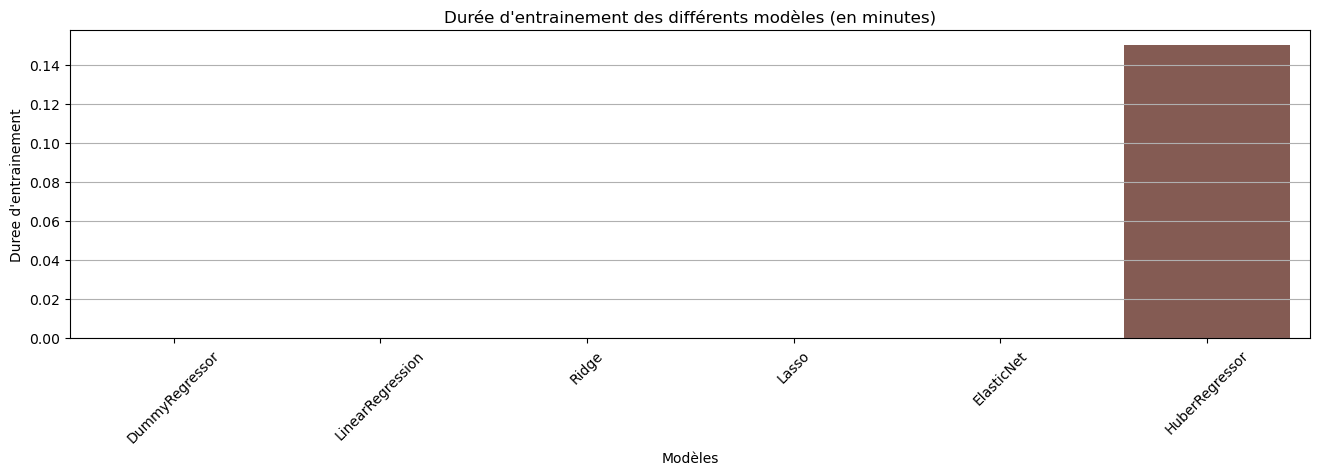

In [33]:
metric_plot(mesure)
graph_time(exe_time)

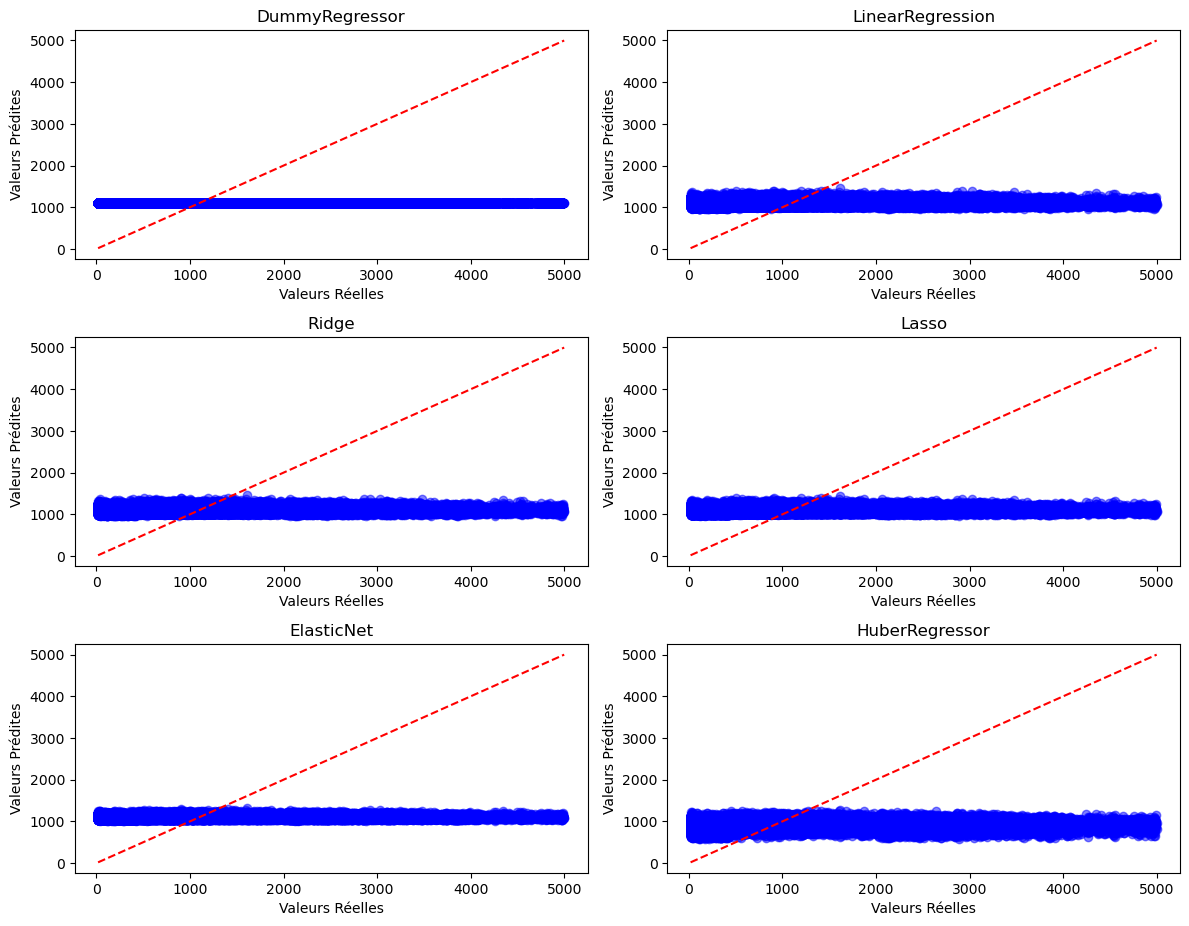

In [34]:
visualisation_pred_real(model_entraine,12,12)

## Observation :
- Première chose à dire, c'est que lors de l'EDA nous avions vu qu'il n'y avait pas spécialement de relation **linéaire** entre la target et les features, or ici nous avons principalement utiliser des modèles de **régression linéaire**

- Concernant les valeurs MSE très élevées, c'est certainement dû aux quelques **valeurs aberrantes** dans nos données, cela peut causer une **MSE élevée**, car les erreurs quadratiques amplifient les grandes différences entre les valeurs réelles et prédites.
- D'ou l'intérêt ici de s'appuyer sur la **MAE** qui mesure la moyenne des erreurs absolues et est **moins sensible** aux **grandes erreurs**

In [35]:
print("Min :", y.min())
print("Max :",y.max())
print("Moyenne :",y.mean())
print("Mediane :",y.median())

Min : 20.0
Max : 4999.0
Moyenne : 1102.5448216666666
Mediane : 872.0


- Les modèles semblent être en underfitting, mais ce n'est en réalité pas le cas, la présence de certains **outliers** dans le jeu de données qui explique cela.
- Nous avons fait ici le choix dans cette premiere modélisation de les laisser, mais rien ne nous empêche de retirer certains outliers qui faciliterai l'étape d'apprentissage des modèles


- Nous avons rajouter ici le modèle **HuberRegressor** qui est moins sensible aux outliers

In [37]:
def read_data(path):
    with open(path, 'rb') as file:
        loaded_file = pickle.load(file)
        name = path.split('/')[-1]
    print(f"Données chargées depuis {colored(path,'blue')} : {colored(name,'green',attrs=['bold'])}")
    return loaded_file

In [40]:
ElasticNet = read_data(os.getcwd()+"\\ElasticNet.pkl")
Huber = read_data(os.getcwd()+"\\HuberRegressor.pkl")

# SVR = read_data(os.getcwd()+"\\SVR.pkl")


Données chargées depuis D:\etude_data_science\kaggle_competition\12_Regression_with_an_Insurance_Dataset\notebook\ElasticNet.pkl : D:\etude_data_science\kaggle_competition\12_Regression_with_an_Insurance_Dataset\notebook\ElasticNet.pkl
Données chargées depuis D:\etude_data_science\kaggle_competition\12_Regression_with_an_Insurance_Dataset\notebook\HuberRegressor.pkl : D:\etude_data_science\kaggle_competition\12_Regression_with_an_Insurance_Dataset\notebook\HuberRegressor.pkl


### Regardons le graphique résiduel pour huber, et un  modèle linéaire (tous ont à peu près les mêmes valeurs)

##### ElasticNet

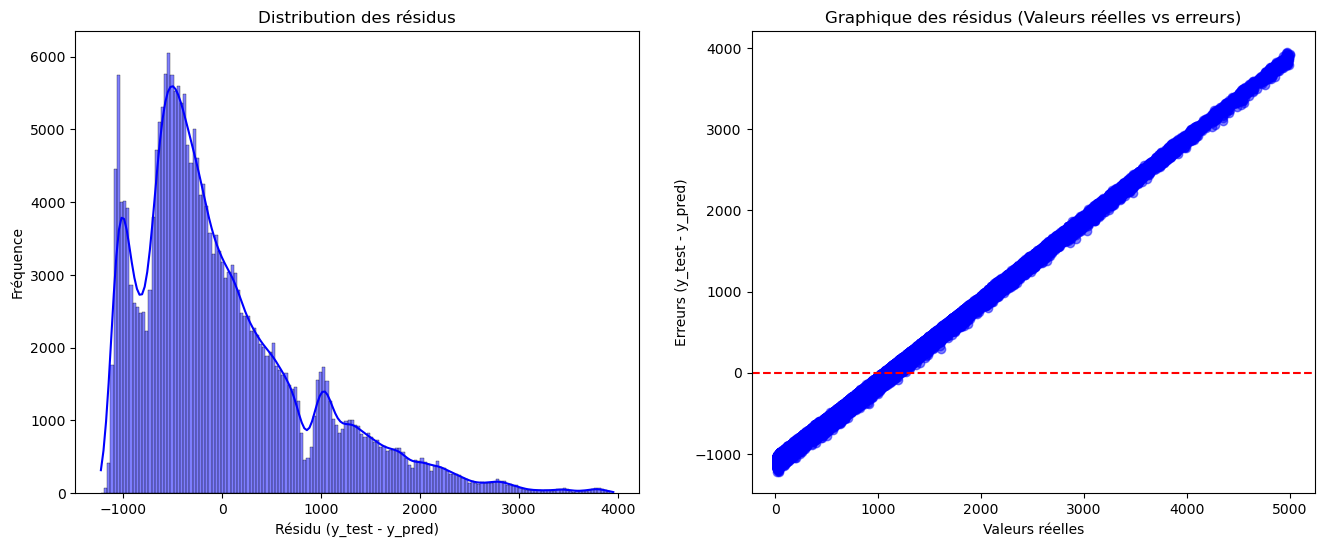

In [41]:
ypred = ElasticNet.predict(X_test)
# Distribution des résidus pour ElasticNet
residuals = y_test - ypred
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, color='blue')
plt.title("Distribution des résidus")
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
plt.scatter(y_test, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="red", linestyle="--")  # Ligne indiquant zéro erreur
plt.title("Graphique des résidus (Valeurs réelles vs erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Erreurs (y_test - y_pred)")
plt.show()


##### Huber :

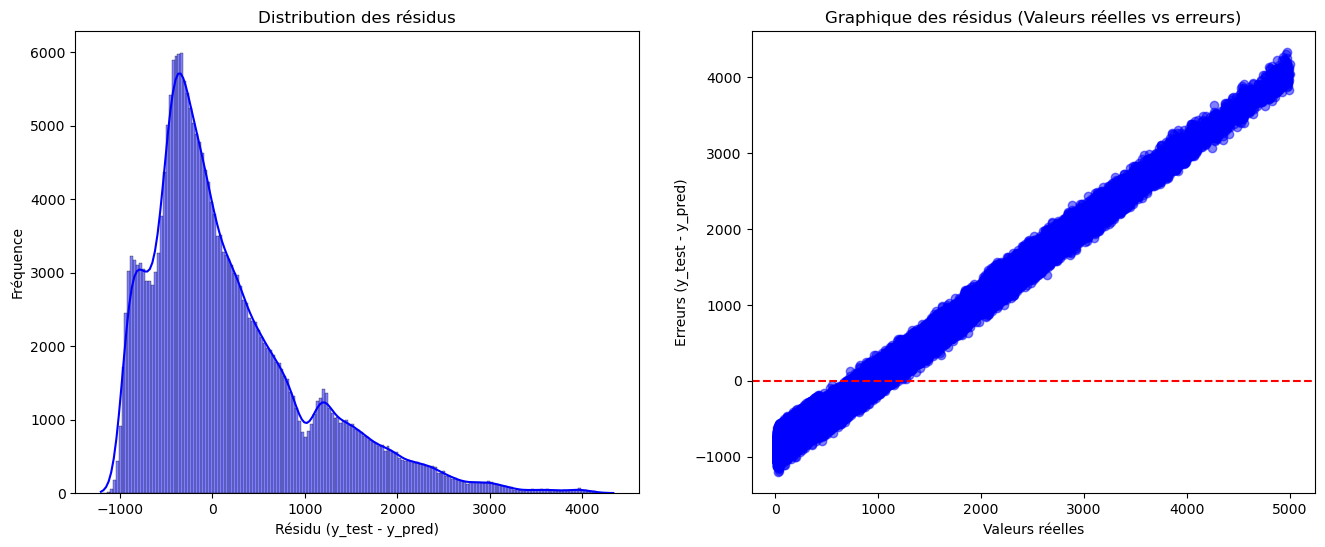

In [42]:
ypred = Huber.predict(X_test)
# Distribution des résidus pour ElasticNet
residuals = y_test - ypred
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, color='blue')
plt.title("Distribution des résidus")
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
plt.scatter(y_test, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="red", linestyle="--")  # Ligne indiquant zéro erreur
plt.title("Graphique des résidus (Valeurs réelles vs erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Erreurs (y_test - y_pred)")
plt.show()


##### SVR : 

Le graphique des résidus et la distribution des résidus sont utilisés pour évaluer la qualité d'un modèle de régression.

- Graphique des résidus :

    * Il montre la différence entre les valeurs réelles et prédites.
    * Si les résidus sont aléatoires (aucune structure visible), cela signifie que le modèle capture bien la relation entre les variables.

    - Une pente dans le graphique des résidus pourrait indiquer un biais dans le modèle, suggérant qu'il n'explique pas correctement les données.
* Distribution des résidus :

    - Elle montre si les résidus suivent une distribution normale. Si la distribution est proche d'une loi normale, cela indique que le modèle est approprié et que les erreurs sont bien réparties.
    - Une pente dans les résidus peut signifier que le modèle n'a pas bien capturé la relation, alors que des résidus aléatoires suggèrent que le modèle est efficace.








# Dans notre cas, c'est la présence de données avec d'outliers qui doit certainement provoquer cet effet de relation mal capturée par le modèle, car les résultats finaux semblent être correct (voir image kaggle a la fin)

In [43]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    prediction = model.predict(X)
    
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(prediction, columns = ["Premium Amount"], index = id_data)
    return prediction_df

In [ ]:
new_prediction(ElasticNet, test).to_csv("prediction_ElasticNet.csv")

In [ ]:
new_prediction(Huber, test).to_csv("prediction_huber.csv")

### Résultat Kaggle : 


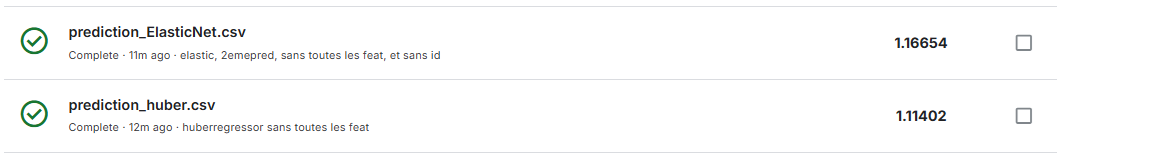

In [45]:
from IPython.display import display, Image

# Charger l'image
img = display(Image('score_kaggle_withoutAllFeat.png'))


* Dans l'ensemble les résultats sont plutôt correct, nous pouvons améliorer cela à l'aide d'un GridSearchCV sur notre modèle ayant eu le meilleur score et qui semble ici plus adapté pour la problématique rencontré
* nous pourrions aussi utiliser un modèle non linéaire et voir les effets (ici la quantité de données importante entraine un entrainement très long pour un modèle type SVR, donc a utiliser sur une portion de données plus réstreinte)

- Nous pouvons aussi utiliser l'autre jeu de données contenant **toutes les features** et voir si réellement elles ont un intérêt dans la prédiction de la target


- Sans surprise c'est le modèle HuberRegressor qui amène un bien meilleur score car il est moins sensible aux outliers